In [1]:
import torch
from torch import Tensor
from math import ceil
from torch.autograd import Function

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [2]:
import triton
import triton.language as tl

In [3]:
def naive_softmax(x:Tensor) -> Tensor:
    max = x.max()
    x -= x.max(dim = -1)[0][:, None] # this is done for numerical stability
    num = torch.exp(x)
    den = torch.sum(num, dim=1)[:, None]
    return num / den

# x = torch.rand(100, 200).to(DEVICE)
# triton.testing.assert_close(naive_softmax(x), torch.nn.functional.softmax(x, dim=1))

In [4]:
@triton.jit
def fused_softmax_kernel(x_pointer, y_pointer, x_stride, y_stride, n_rows, n_cols, block_size: tl.constexpr):
    # get the program id: each program of the grid handles one (or more) rows of the tensor
    pid = tl.program_id(axis=0)

    # strided execution: can run the program in a strided way (e.g. for row 0, 8, 16, ...)
    row_step = tl.num_programs(axis=0) # n. of programs running on given axis

    # loop through the rows executed by program with this pid
    for row_idx in tl.range(pid, n_rows, row_step):
        x_row_pointer = x_pointer + row_idx * x_stride

        col_offset = tl.arange(0, block_size)
        x_col_pointer = x_row_pointer + col_offset

        # Create a mask to guard memory operations against out-of-bounds accesses.
        mask = col_offset < n_cols

        # compute the softmax (with shift for numerical stab.)
        row = tl.load(x_col_pointer, mask, other=-float('inf'))

        row_minus_max = row - tl.max(row, axis=0)
        num = tl.exp(row_minus_max)
        den = tl.sum(num, axis=0)
        y = num / den

        y_row_pointer = y_pointer + row_idx * y_stride
        y_col_pointer = y_row_pointer + col_offset
        tl.store(y_col_pointer, y, mask)


def fused_softmax_triton(x:Tensor, block_size:int=1024) -> Tensor:
    assert x.is_cuda

    n_rows, n_cols = x.shape
    y = torch.empty_like(x)
    grid = n_rows,
    BLOCK_SIZE = triton.next_power_of_2(n_cols)  # Used to tile the row

    fused_softmax_kernel[grid](x, y, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE)

    return y




In [5]:
x = torch.rand(8, 16).to(DEVICE)
assert torch.allclose(naive_softmax(x), fused_softmax_triton(x))



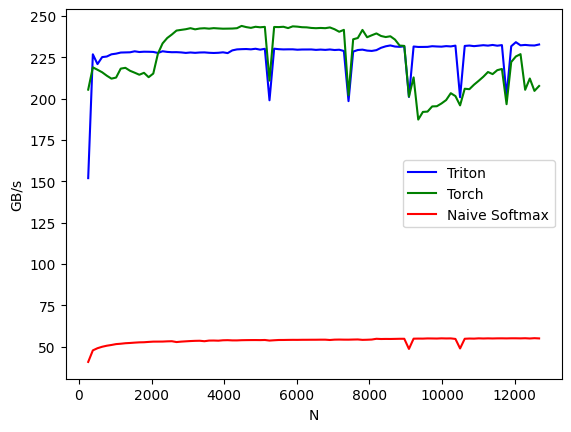

softmax-performance:
          N      Triton       Torch  Naive Softmax
0     256.0  151.980123  205.490514      40.853169
1     384.0  226.857512  218.978525      47.838907
2     512.0  220.938893  217.514575      49.142157
3     640.0  225.161262  215.992813      50.020996
4     768.0  225.520422  213.928680      50.652093
5     896.0  226.857004  212.147934      51.098348
6    1024.0  227.260291  212.789449      51.628142
7    1152.0  227.920769  218.205495      51.850982
8    1280.0  228.001137  218.683343      52.156157
9    1408.0  228.074304  216.898847      52.310863
10   1536.0  228.673505  215.738704      52.518491
11   1664.0  228.243074  214.505242      52.688767
12   1792.0  228.429241  215.666179      52.751406
13   1920.0  228.390875  213.019784      52.955124
14   2048.0  228.298355  215.220412      53.123225
15   2176.0  227.672494  227.257940      53.139178
16   2304.0  228.697633  233.448524      53.161717
17   2432.0  228.307958  236.712890      53.294922
18   2560.

In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: fused_softmax_triton(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)